## Miniproject 2: MovieLens Visualization



### Download data

In [ ]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [ ]:
import pandas as pd

data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

Basic Visualizations

All Ratings in the MovieLens Dataset

Text(0.5, 1.0, 'All Movie Ratings')

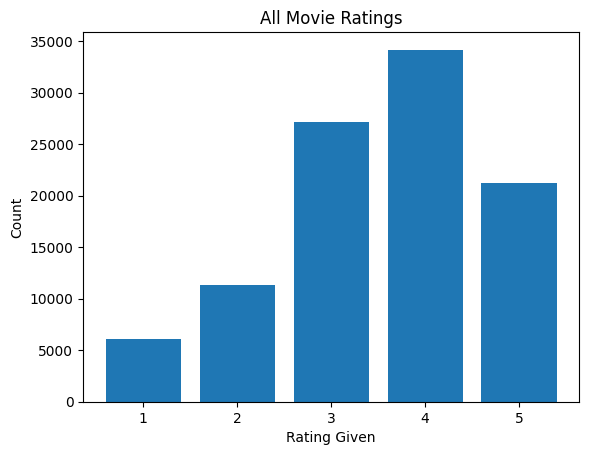

In [ ]:
freq = []

for i in range(1, 6):
  freq.append(list(data['Rating']).count(i))

plt.bar(range(1, 6), freq)
plt.xlabel('Rating Given')
plt.ylabel('Count')
plt.title("All Movie Ratings")

All ratings of the ten most popular movies. The ten most popular movies is defined by the ten movies with the most ratings.

In [ ]:
freq_counter = Counter(data['Movie ID'])

top_10 = freq_counter.most_common(10)

print(top_10)

[(50, 583), (258, 509), (100, 508), (181, 507), (294, 485), (286, 481), (288, 478), (1, 452), (300, 431), (121, 429)]


Text(0.5, 1.0, 'Ratings of Ten Most Popular Movies')

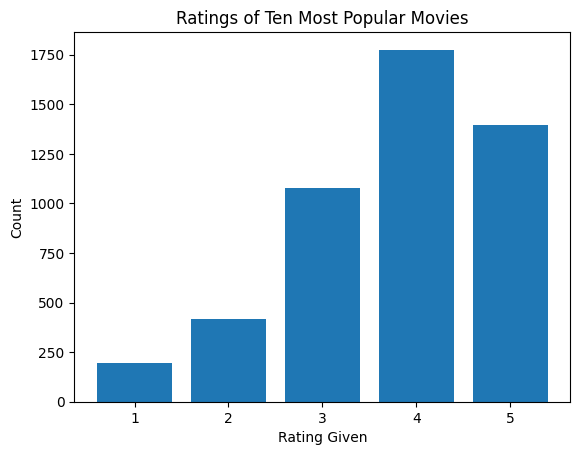

In [ ]:
ratings = []

for i in range(10):
  movie_id = top_10[i][0]
  filter_ratings = data[data['Movie ID'] == movie_id]
  ratings.extend(list(filter_ratings['Rating']))

freq = []

for i in range(1, 6):
  freq.append(ratings.count(i))

plt.bar(range(1, 6), freq)
plt.xlabel('Rating Given')
plt.ylabel('Count')
plt.title("Ratings of Ten Most Popular Movies")

All ratings of the ten best movies. The ten best movies is defined by the ten movies with the highest average ratings.

4.491071428571429
[408, 318, 169, 483, 64, 603, 12, 50, 178, 134, 427, 357, 98, 480, 127, 122, 243, 325, 260, 358, 29, 231, 259, 926, 264, 240, 554, 678, 1047, 235]


Text(0.5, 1.0, 'Ratings of the Ten Best Movies')

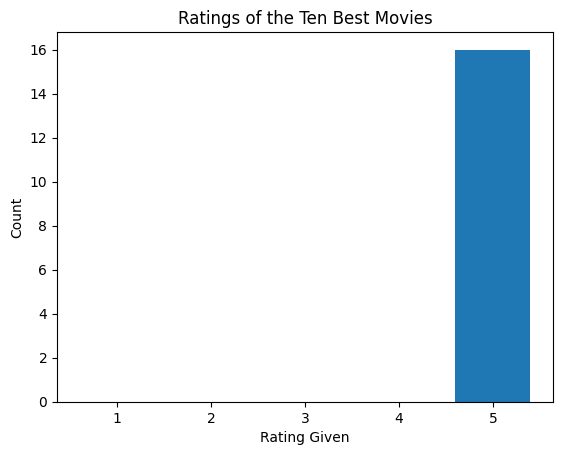

In [ ]:
movie_ids = set(list(data['Movie ID']))

Average = {}

Pop_avg = {}

for i in data['Movie ID'].unique():
  filter_ratings = data[data['Movie ID'] == i]
  Average[i] = np.mean(list(filter_ratings['Rating']))
  if len(list(filter_ratings['Rating'])) > 100:
    Pop_avg[i] = np.mean(list(filter_ratings['Rating']))

print(np.mean(data[data['Movie ID'] == 408]['Rating']))
sorted_averages = sorted(Average.items(), key = lambda x: x[1], reverse = True)

pop_best = sorted(Pop_avg.items(), key = lambda x: x[1], reverse = True)
pop_worst = sorted(Pop_avg.items(), key = lambda x: x[1], reverse = False)

pop_10 = [item[0] for item in pop_best[:15]]
pop_10.extend([item[0] for item in pop_worst[:15]])
print(pop_10)

top_10 = [item[0] for item in sorted_averages[:10]]

top_ratings = list(data[data['Movie ID'].isin(top_10)]['Rating'])

freq = []

for i in range(1, 6):
  freq.append(top_ratings.count(i))

plt.bar(range(1, 6), freq)
plt.xlabel('Rating Given')
plt.ylabel('Count')
plt.title("Ratings of the Ten Best Movies")

All ratings of movies from the Action, Comedy, and Crime genres. We have included all three graphs.

In [ ]:
def graph_genre(genre):
  genre_movie = movies[genre]

  genres = movies[movies[genre] == 1]

  genre_movies = list(genres['Movie ID'])

  ratings = data[data['Movie ID'].isin(genre_movies)]['Rating']
  freq = []

  for i in range(1, 6):
    freq.append(list(ratings).count(i))

  plt.bar(range(1, 6), freq)
  plt.xlabel('Rating Given')
  plt.ylabel('Count')
  plt.title('Ratings for {:} movies'.format(genre))
  plt.show()

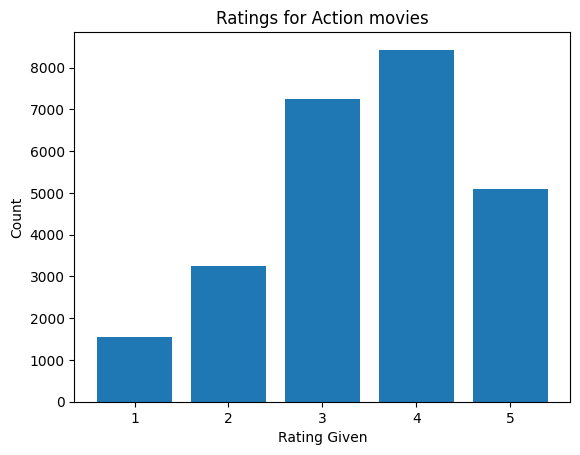

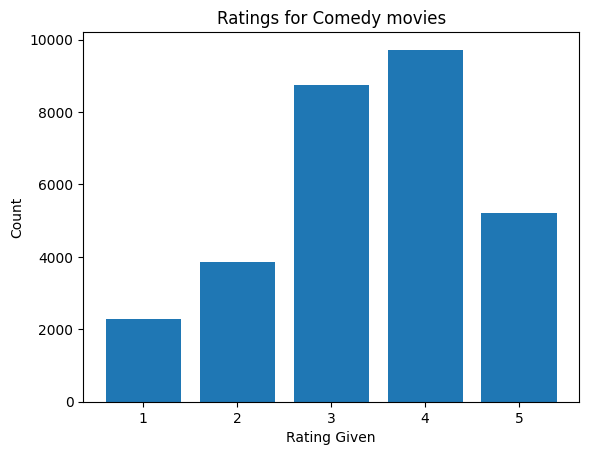

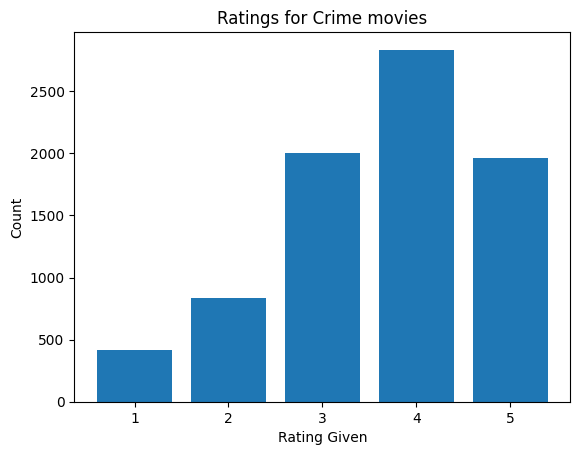

In [ ]:
graph_genre('Action')
graph_genre('Comedy')
graph_genre('Crime')

Matrix Factorization Visualizations

Approach #1. This code is adapted from last week's homework.

In [ ]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * ((reg * Ui) - (Vj * (Yij - np.dot(Vj, Ui))))

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * ((reg * Vj) - (Ui * (Yij - np.dot(Vj, Ui))))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """

    regular = reg * .5 * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2)

    errs = .5 * np.sum([(Y_ij - np.dot(V[j - 1], U[i - 1]))**2 for i, j, Y_ij in Y])

    return (regular + errs) / len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    first_epoch = False
    U = np.random.uniform(-.5, .5, (M, K))
    V = np.random.uniform(-.5, .5, (N, K))
    init_mse = get_err(U, V, Y, reg)
    first_mse = 0
    prev_mse = 0

    for i in range(max_epochs):
      epoch = np.random.permutation(len(Y))
      for i in epoch:
        U[Y[i][0] - 1] -= grad_U(U[Y[i][0] - 1], Y[i][2], V[Y[i][1] - 1], reg, eta)
        V[Y[i][1] - 1] -= grad_V(V[Y[i][1] - 1], Y[i][2], U[Y[i][0] - 1], reg, eta)

      if first_epoch is True and (get_err(U, V, Y, reg) - prev_mse) / (first_mse - init_mse) < eps:
        break

      if first_epoch is False:
        first_mse = get_err(U, V, Y, reg)
        prev_mse = get_err(U, V, Y, reg)
        first_epoch = True

      prev_mse = get_err(U, V, Y, reg)

    return(U, V, get_err(U, V, Y, reg))

Below is a heat map that we developed to find the optimal eta and reg values to reduce E_out.

<Axes: >

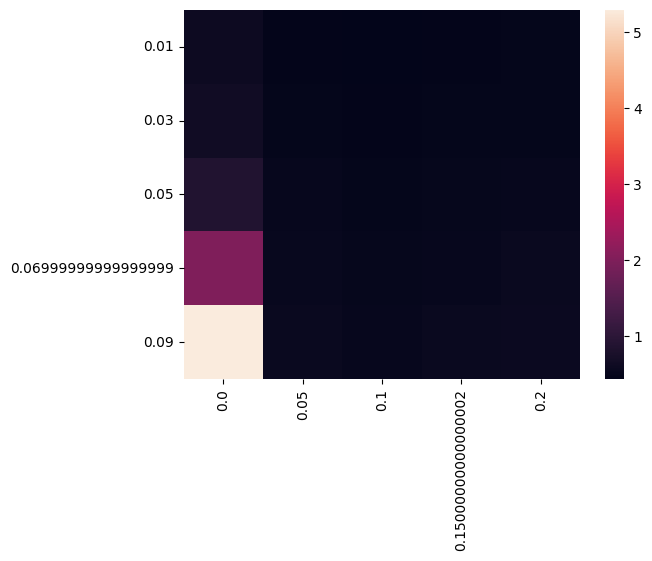

In [ ]:
grids = np.ones([5, 5])

train = np.array(train).astype(int)
test = np.array(test).astype(int)

etas = np.linspace(.01, .09, 5)
regs = np.linspace(0.0, .2, 5)

i = 0
j = 0
for eta in etas:
  for reg in regs:
    U, V, err = train_model(943, 1682, 20, eta, reg, train)

    grids[i, j] = (get_err(U, V, test))
    j += 1

  j = 0
  i += 1

heat = pd.DataFrame(grids, index = etas, columns = regs)

plt.ylabel('learning rate')
plt.xlabel('regularization value')

sns.heatmap(heat)

Our results dictate that eta = 0.01 and reg = 0.1 gave lowest test error.

Text(50.722222222222214, 0.5, 'learning rate (eta)')

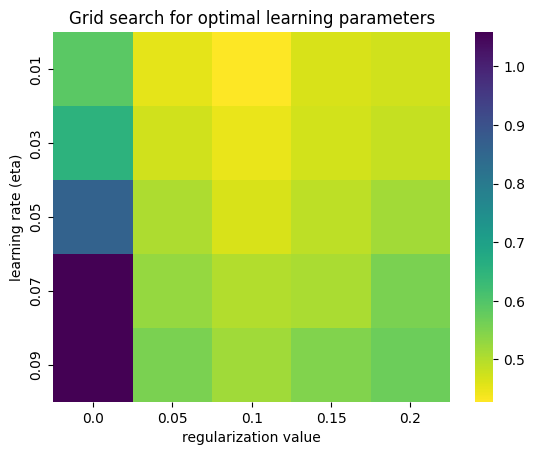

In [ ]:
heat = pd.DataFrame(grids, index = [.01, .03, .05, .07, .09], columns = [0.0, .05, .1, .15, .2])

sns.heatmap(heat, cmap = 'viridis_r', vmin=heat.values.min(), vmax=heat.values.max() * 0.2)

plt.title('Grid search for optimal learning parameters')
plt.xlabel('regularization value')
plt.ylabel('learning rate (eta)')

Approach 2. In this code we incorporated bias terms a and b for each user and each movie.

In [ ]:
def bias_grad_U(Ui, Yij, Vj, ai, bj,  reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * ((reg * Ui) - (Vj * (Yij - np.dot(Vj, Ui) - ai - bj)))

def bias_grad_V(Vj, Yij, Ui, ai, bj,  reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * ((reg * Vj) - (Ui * (Yij - np.dot(Vj, Ui) - ai - bj)))

def bias_grad_bias(Vj, Yij, Ui, ai, bj,  reg, eta):
    return eta * -1 * (Yij - np.dot(Vj, Ui) - ai - bj)

def bias_get_err(U, V, Y,a , b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """

    error = 0
    for i in range(len(Y)):
      (i, j, Y_ij) = Y[i]

      pred = np.dot(U[i -1], V[j-1]) + a[i - 1] + b[j - 1]
      error += .5 * ((Y_ij - pred) **2)

    error += .5 * reg * (np.linalg.norm(U) ** 2 + np.linalg.norm(V) ** 2)

    return error / len(Y)

def bias_train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    first_epoch = False
    U = np.random.uniform(-.5, .5, (M, K))
    V = np.random.uniform(-.5, .5, (N, K))
    a = np.random.uniform(-.5, .5, (M, 1))
    b = np.random.uniform(-.5, .5, (N, 1))
    init_mse = get_err(U, V, Y, reg)
    first_mse = 0
    prev_mse = 0

    for i in range(max_epochs):
      epoch = np.random.permutation(len(Y))
      for i in epoch:
        U[Y[i][0] - 1] -= bias_grad_U(U[Y[i][0] - 1], Y[i][2], V[Y[i][1] - 1], a[Y[i][0] - 1], b[Y[i][1] - 1], reg, eta)
        V[Y[i][1] - 1] -= bias_grad_V(V[Y[i][1] - 1], Y[i][2], U[Y[i][0] - 1], a[Y[i][0] - 1], b[Y[i][1] - 1], reg, eta)
        bias_step = bias_grad_bias(V[Y[i][1] - 1], Y[i][2], U[Y[i][0] - 1], a[Y[i][0] - 1], b[Y[i][1] - 1], reg, eta)
        a[Y[i][0] - 1] -= bias_step
        b[Y[i][1] - 1] -= bias_step

      if first_epoch is True and (get_err(U, V, Y, reg) - prev_mse) / (first_mse - init_mse) < eps:
        break

      if first_epoch is False:
        first_mse = bias_get_err(U, V, Y, a, b, reg)
        prev_mse = bias_get_err(U, V, Y, a, b, reg)
        first_epoch = True

      prev_mse = bias_get_err(U, V, Y, a, b, reg)

    return(U, V, a, b, bias_get_err(U, V, Y, a, b, reg))

In [ ]:
train = np.array(train).astype(int)
test = np.array(test).astype(int)

<ipython-input-41-455bd57b3f22>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grids[i, j] = (bias_get_err(U, V, test,a , b))


Text(50.722222222222214, 0.5, 'learning rate (eta)')

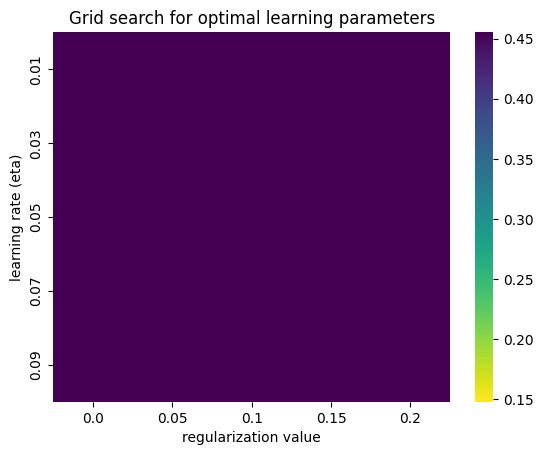

In [ ]:
grids = np.ones([5, 5])

train = np.array(train).astype(int)
test = np.array(test).astype(int)

etas = np.linspace(.01, .09, 5)
regs = np.linspace(0.0, .2, 5)

i = 0
j = 0
for eta in etas:
  for reg in regs:
    U, V, a, b, err = bias_train_model(943, 1682, 20, eta, reg, train)

    grids[i, j] = (bias_get_err(U, V, test,a , b))
    j += 1

  j = 0
  i += 1


heat = pd.DataFrame(grids, index = [.01, .03, .05, .07, .09], columns = [0.0, .05, .1, .15, .2])

sns.heatmap(heat, cmap = 'viridis_r', vmin=heat.values.min(), vmax=heat.values.max() * 0.2)

plt.title('Grid search for optimal learning parameters')
plt.xlabel('regularization value')
plt.ylabel('learning rate (eta)')

In [ ]:
print(heat)

          0.00      0.05      0.10      0.15      0.20
0.01  0.629482  0.615703  0.601503  0.597909  0.595709
0.03  0.524895  0.484034  0.479583  0.477737  0.476449
0.05  0.551213  0.479416  0.461542  0.460307  0.466109
0.07  0.660822  0.491742  0.455328  0.458148  0.468065
0.09  0.822380  0.514200  0.467463  0.456625  0.467072


Below we apply SVD to V and use the first two columns of A to project into 2-D space. We do this to construct useful visualizations that are included below.

In [ ]:
U_bias, V_bias, a_bias, b_bias, err_bias = bias_train_model(943, 1682, 20, .07, 0.1, train)

A_bias = np.linalg.svd(V_bias.transpose())[0]

U_tilde_bias = np.dot(A_bias[:,:2].transpose(), U_bias.transpose())
V_tilde_bias = np.dot(A_bias[:,:2].transpose(), V_bias.transpose())

In [ ]:
U, V, err = train_model(943, 1682, 20, .01, 0.1, train)

A = np.linalg.svd(V.transpose())[0]

U_tilde = np.dot(A[:,:2].transpose(), U.transpose())
V_tilde = np.dot(A[:,:2].transpose(), V.transpose())

In [ ]:
movie_id_list = ['Star Trek: The Motion Picture (1979)', 'Star Trek V: The Final Frontier (1989)', 'Star Trek VI: The Undiscovered Country (1991)',
 'Star Trek: The Wrath of Khan (1982)', 'Star Trek III: The Search for Spock (1984)', 'Willy Wonka and the Chocolate Factory (1971)', 'Groundhog Day (1993)',
                 'Happy Gilmore (1996)', 'Dumb & Dumber (1994)', "Gilligan's Island: The Movie (1998)"]

ids = list(movies[movies['Movie Title'].isin(movie_id_list)]['Movie ID'])

ids = [x - 1 for x in ids]

Below we created many plotting functions to aid in creation of the required visualizations.

In [ ]:
def plot_data(names , coordinates, indices, title, factor = 10):
  test_ids = [x + 1 for x in indices]

  freq_ratings = data[data['Movie ID'].isin(test_ids)]['Movie ID']

  frequency_table = Counter(freq_ratings)

  freq_dict = dict(frequency_table)

  freq_list = (list(freq_dict.values()))

  freq_list = [x * factor for x in freq_list]

  if factor != 10:
    print(freq_list)

  avg_list = []

  for i in test_ids:
    filter_ratings = data[data['Movie ID'] == i]
    avg_list.append(np.mean(list(filter_ratings['Rating'])))

  plt.figure(figsize = (10, 10))
  plt.scatter(coordinates[0], coordinates[1], s = freq_list, c = avg_list, cmap = 'cool', alpha = .7)
  plt.colorbar().set_label('Rating')

  for i, label in enumerate(names):
    plt.annotate(label, (coordinates[0, i], coordinates[1, i]))

  plt.xlabel("Component 1")
  plt.ylabel("Component 2")
  plt.title(title)
  plt.show()

In [ ]:
def plotting_any(V_tilde, id_list):
  movie_names = np.array(movies['Movie Title'])
  indices = id_list
  coordinates = V_tilde[:, indices]
  names = movie_names[indices]
  print(names)

  plot_data(names, coordinates, indices, "Any Ten Movies")

def plotting_popular(V_tilde):
  movie_names = np.array(movies['Movie Title'])
  indices = [50,258,100,181,294,286,288,1,300,121]
  indices = [x-1 for x in indices]
  coordinates = V_tilde[:, indices]
  names = movie_names[indices]

  plot_data(names, coordinates, indices, "Ten Most Popular Movies")

def plotting_best(V_tilde):
  movie_names = np.array(movies['Movie Title'])
  indices = [1189,1500,814,1536,1293,1599,1653,1467,1122,1201]
  indices = [x-1 for x in indices]
  coordinates = V_tilde[:, indices]
  names = movie_names[indices]

  plot_data(names, coordinates, indices, "Ten Best Movies", factor = 500)

def plotting_action(V_tilde):
  movie_names = np.array(movies['Movie Title'])
  indices = [2, 4, 17, 21, 22, 24, 27, 28, 29, 33]
  indices = [x-1 for x in indices]
  coordinates = V_tilde[:, indices]
  names = movie_names[indices]

  plot_data(names, coordinates, indices, "Any Ten Action Movies")

def plotting_comedy(V_tilde):
  movie_names = np.array(movies['Movie Title'])
  indices = [21, 25, 26, 29, 34, 40, 41, 42, 45, 47]
  indices = [x-1 for x in indices]
  coordinates = V_tilde[:, indices]
  names = movie_names[indices]

  plot_data(names, coordinates, indices, "Any Ten Comedy Movies")

def plotting_crime(V_tilde):
  movie_names = np.array(movies['Movie Title'])
  indices = [100, 120, 127, 129, 130, 156, 182, 187, 194, 231]
  indices = [x-1 for x in indices]
  coordinates = V_tilde[:, indices]
  names = movie_names[indices]

  plot_data(names, coordinates, indices, "Any Ten Crime Movies")

Below are the visualizations as a result of Method 1.

['Close Shave, A (1995)' "Schindler's List (1993)"
 'Wrong Trousers, The (1993)' 'Casablanca (1942)'
 'Shawshank Redemption, The (1994)' 'Rear Window (1954)'
 'Usual Suspects, The (1995)' 'Star Wars (1977)' '12 Angry Men (1957)'
 'Citizen Kane (1941)' 'To Kill a Mockingbird (1962)'
 "One Flew Over the Cuckoo's Nest (1975)"
 'Silence of the Lambs, The (1991)' 'North by Northwest (1959)'
 'Godfather, The (1972)' 'Cable Guy, The (1996)' 'Jungle2Jungle (1997)'
 'Crash (1996)' 'Event Horizon (1997)' 'Spawn (1997)'
 'Batman Forever (1995)' 'Batman Returns (1992)'
 'George of the Jungle (1997)' 'Down Periscope (1996)' 'Mimic (1997)'
 'Beavis and Butt-head Do America (1996)' 'Waterworld (1995)'
 'Volcano (1997)' 'Multiplicity (1996)' 'Mars Attacks! (1996)']


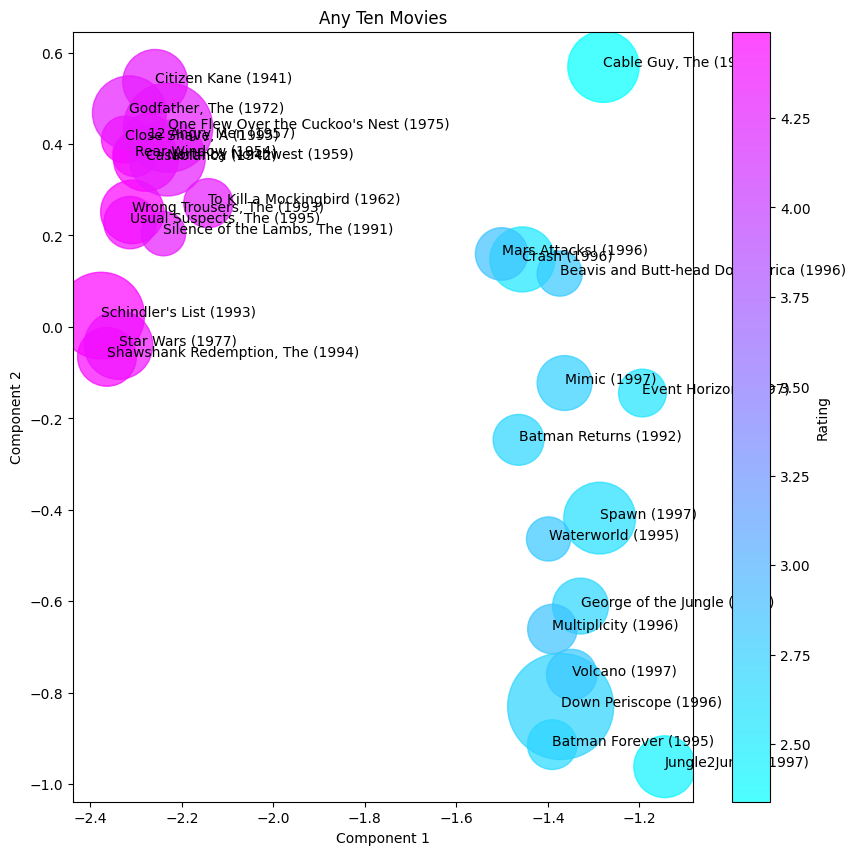

['Willy Wonka and the Chocolate Factory (1971)' 'Groundhog Day (1993)'
 'Star Trek VI: The Undiscovered Country (1991)'
 'Star Trek: The Wrath of Khan (1982)'
 'Star Trek III: The Search for Spock (1984)'
 'Star Trek: The Motion Picture (1979)'
 'Star Trek V: The Final Frontier (1989)' 'Happy Gilmore (1996)'
 'Dumb & Dumber (1994)' "Gilligan's Island: The Movie (1998)"]


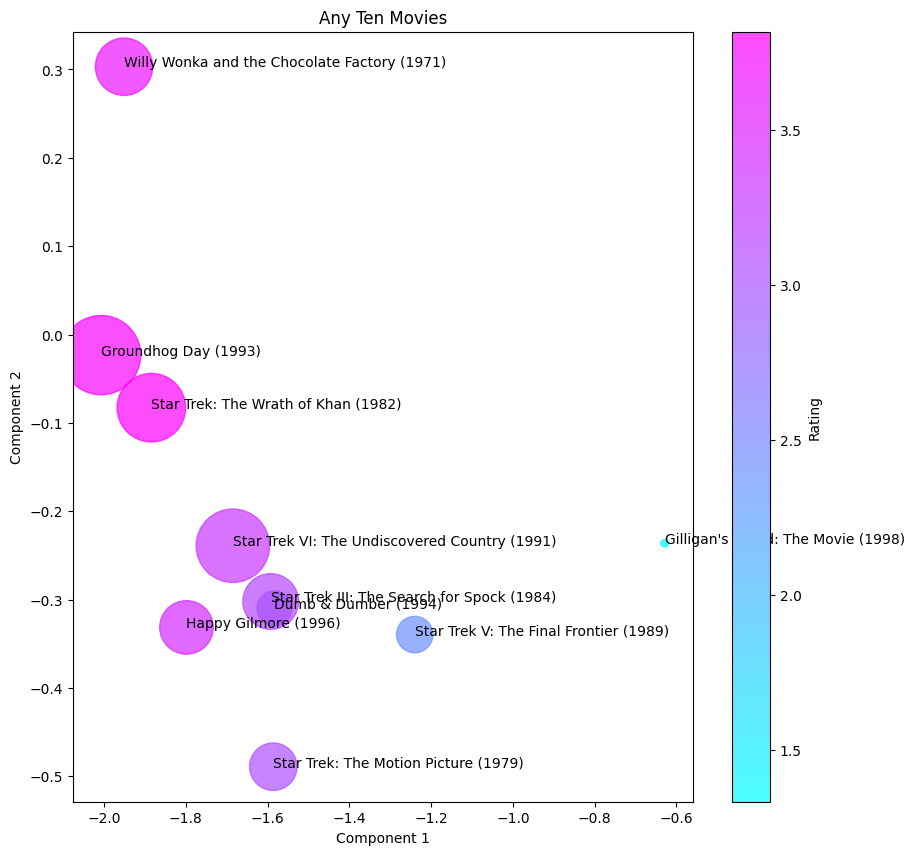

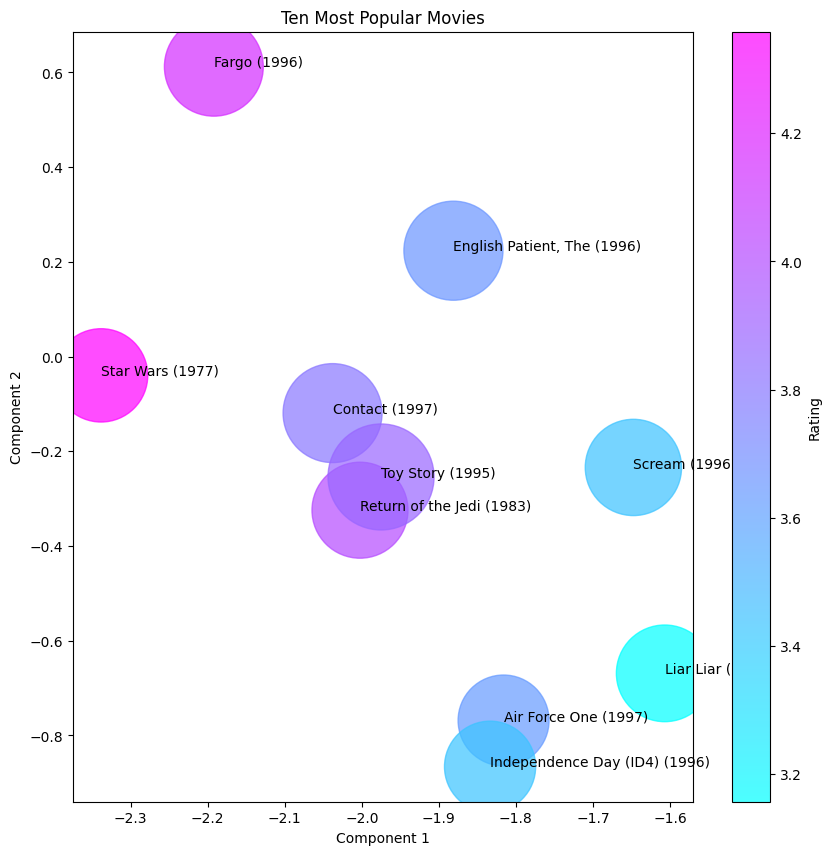

[1500, 1000, 500, 500, 1500, 500, 500, 1000, 500, 500]


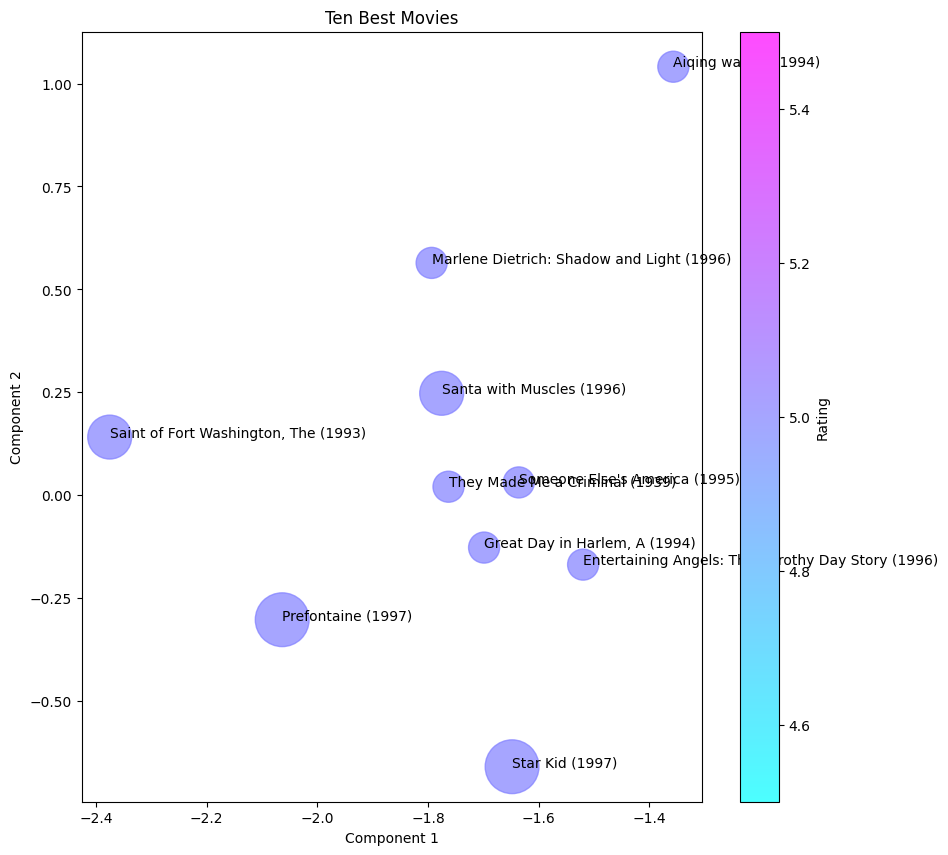

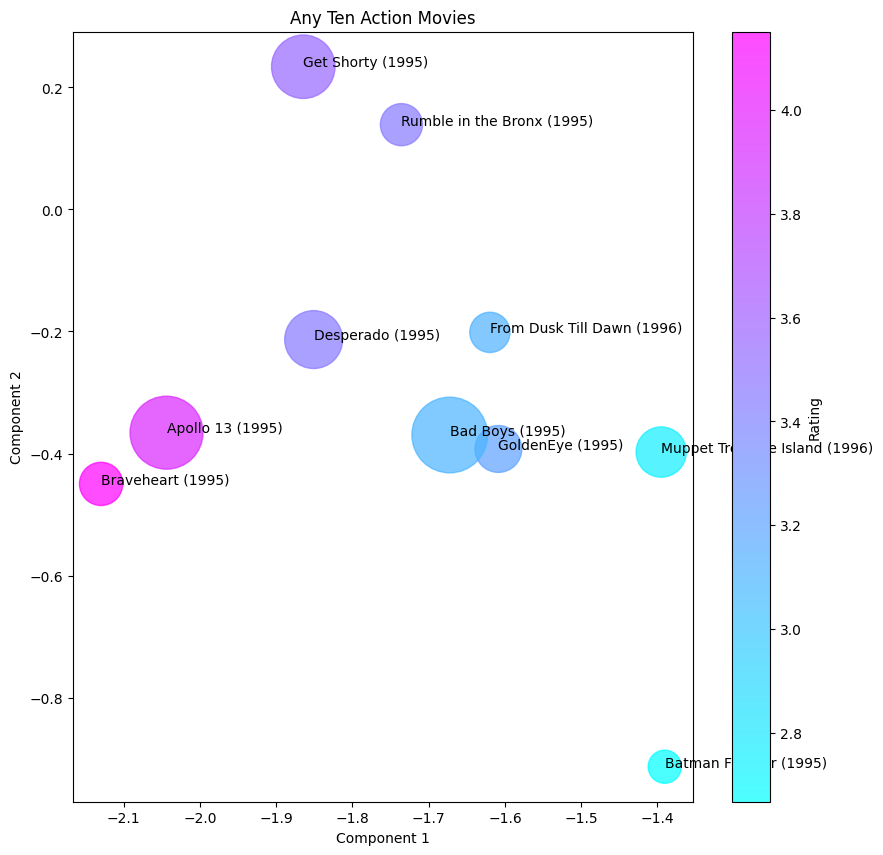

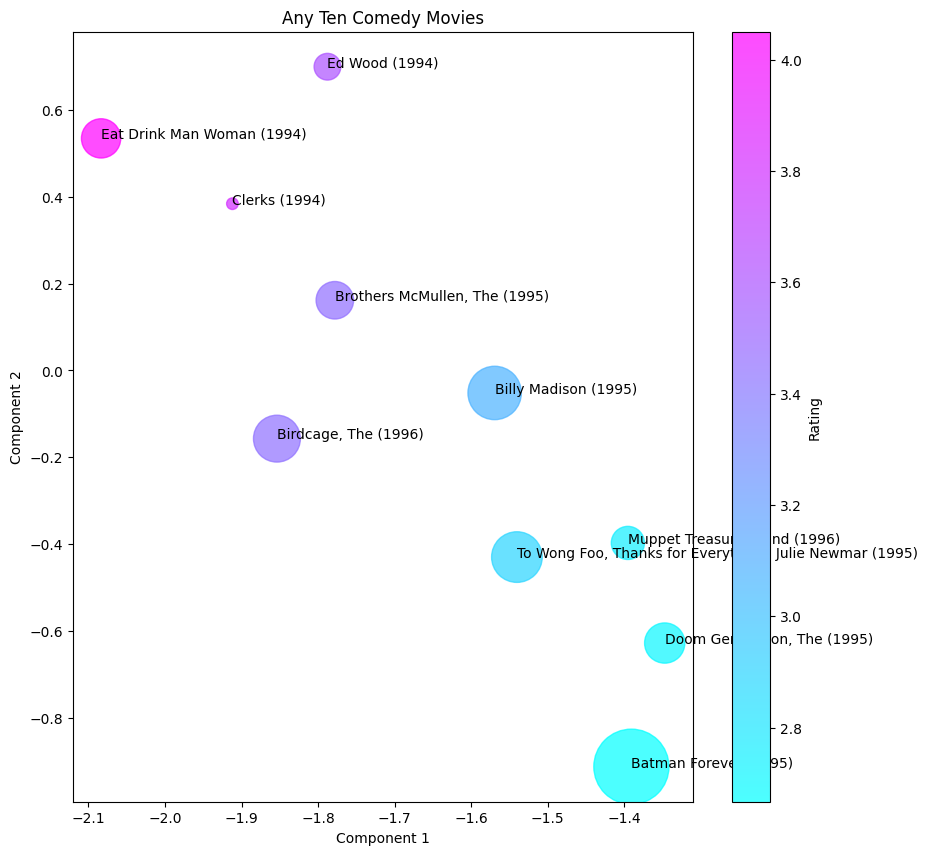

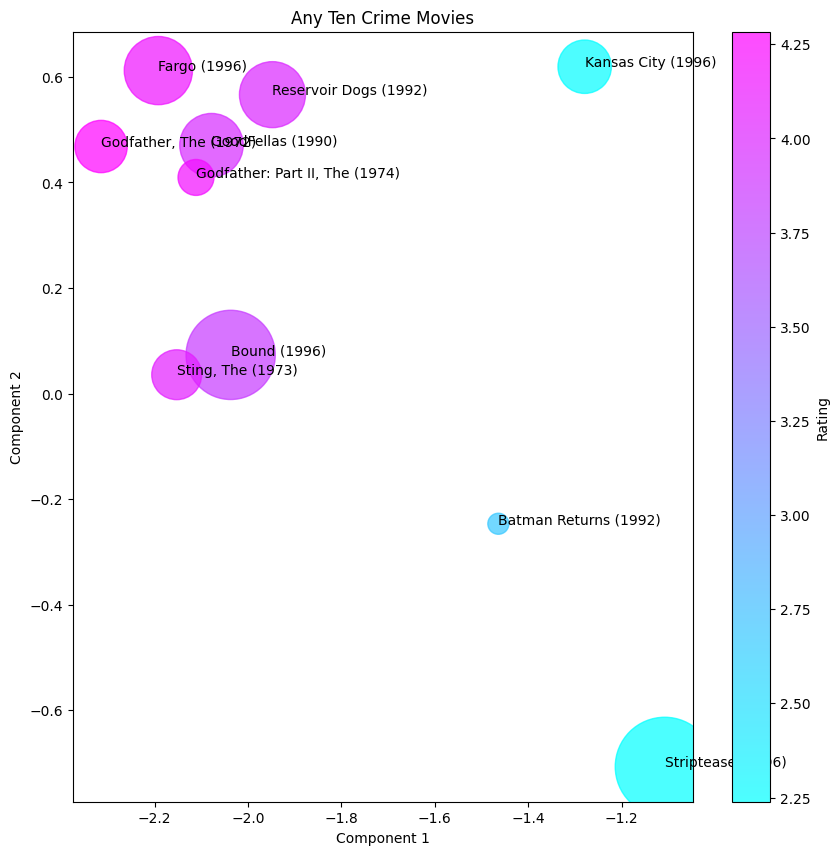

In [ ]:
plotting_any(V_tilde, [x - 1 for x in pop_10])
plotting_any(V_tilde, ids)
plotting_popular(V_tilde)
plotting_best(V_tilde)
plotting_action(V_tilde)
plotting_comedy(V_tilde)
plotting_crime(V_tilde)

Below are the visualizations that are required as a result of Method 2.

['Willy Wonka and the Chocolate Factory (1971)' 'Groundhog Day (1993)'
 'Star Trek VI: The Undiscovered Country (1991)'
 'Star Trek: The Wrath of Khan (1982)'
 'Star Trek III: The Search for Spock (1984)'
 'Star Trek: The Motion Picture (1979)'
 'Star Trek V: The Final Frontier (1989)' 'Happy Gilmore (1996)'
 'Dumb & Dumber (1994)' "Gilligan's Island: The Movie (1998)"]


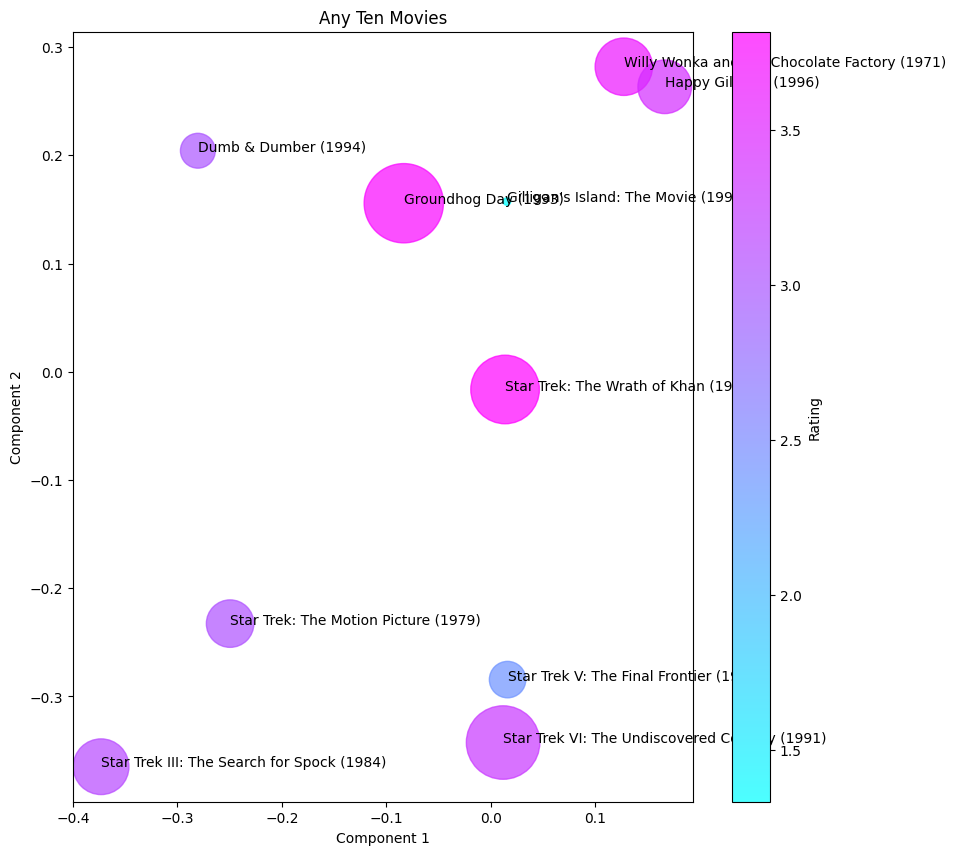

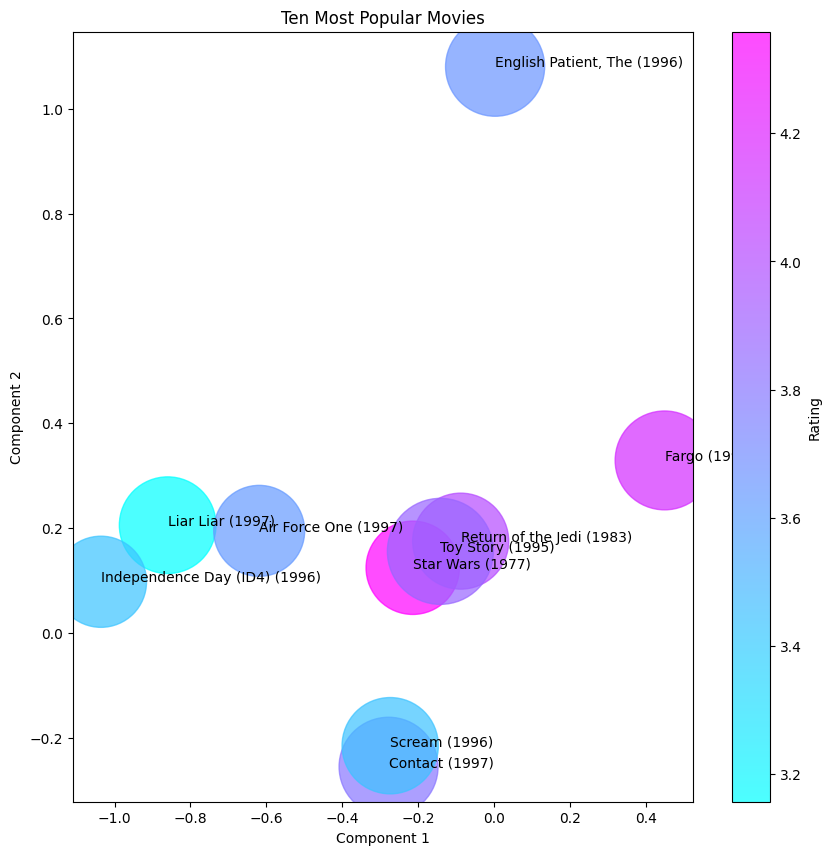

[1500, 1000, 500, 500, 1500, 500, 500, 1000, 500, 500]


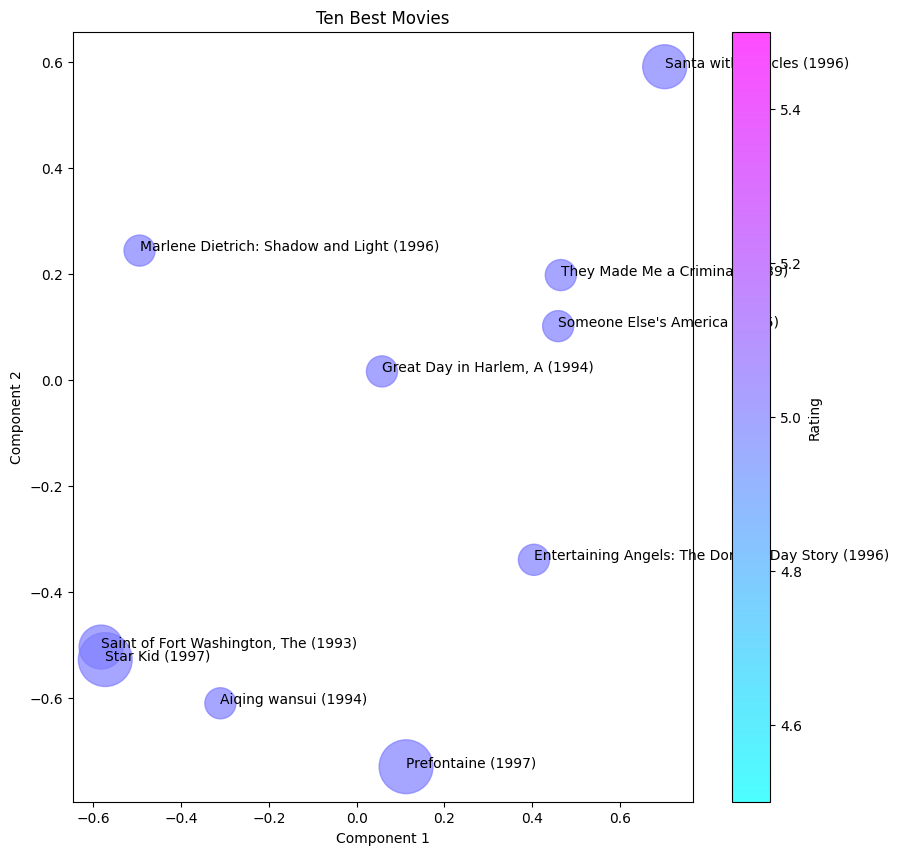

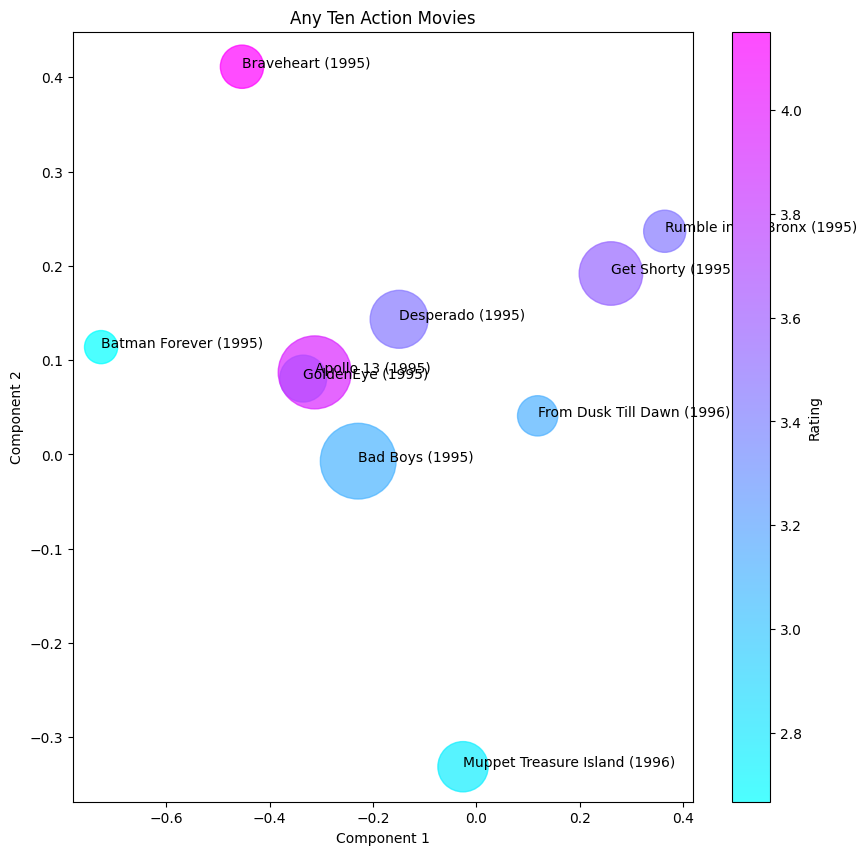

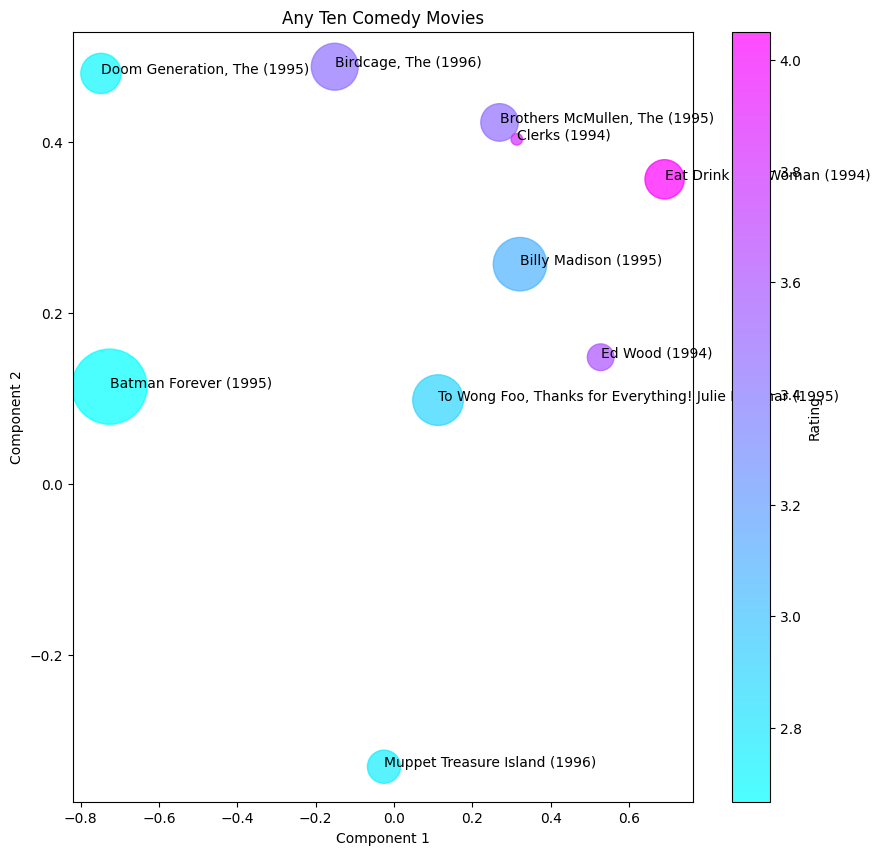

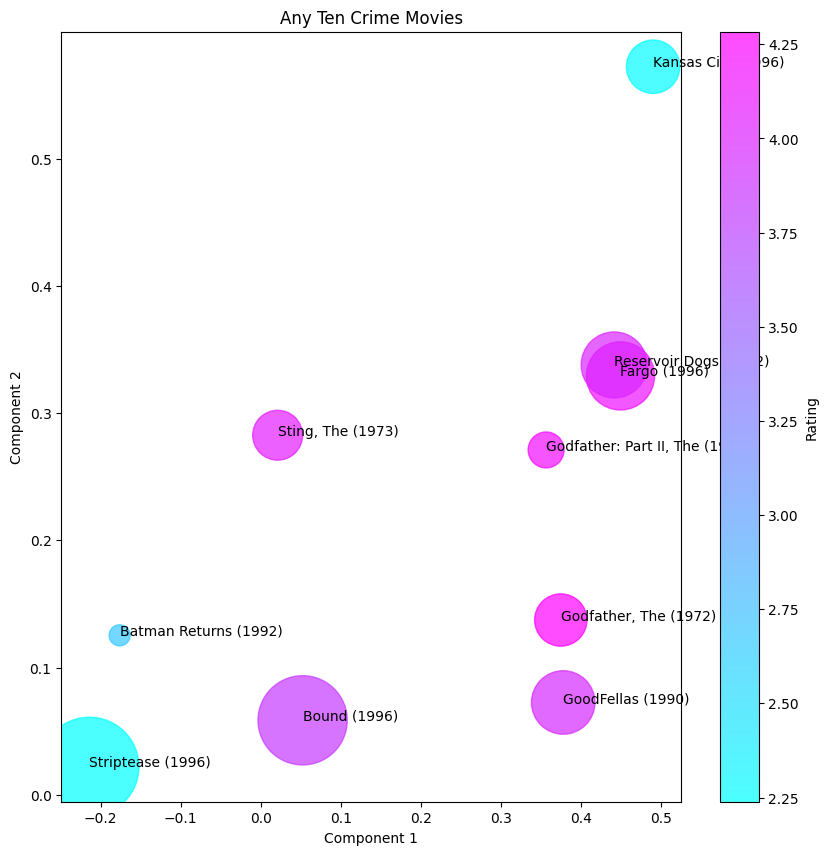

In [ ]:
plotting_any(V_tilde_bias, ids)
plotting_popular(V_tilde_bias)
plotting_best(V_tilde_bias)
plotting_action(V_tilde_bias)
plotting_comedy(V_tilde_bias)
plotting_crime(V_tilde_bias)

Below is the implementation of Method 3. It is a surprise SVD and an off-the-shelf implementation. We imported from the surprise library.

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163008 sha256=ed20768c5477bc7c531b496c4767bfe64365598824d3af43d565435bf16f876b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy

In [ ]:
reader = Reader()
dataset = Dataset.load_from_df(data, reader)

algo = SVD(n_factors=20, n_epochs = 300, lr_all=0.01, reg_all=0.1, biased=True)
cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9274  0.9187  0.9179  0.9227  0.9186  0.9210  0.0036  
MAE (testset)     0.7300  0.7250  0.7215  0.7274  0.7238  0.7255  0.0029  
Fit time          21.23   12.11   12.11   12.18   12.11   13.95   3.64    
Test time         0.33    0.12    0.12    0.23    0.11    0.18    0.09    


{'test_rmse': array([0.92736293, 0.91865522, 0.91794878, 0.92267158, 0.91856622]),
 'test_mae': array([0.72998712, 0.72497851, 0.72149843, 0.72740628, 0.72380995]),
 'fit_time': (21.232630252838135,
  12.10822081565857,
  12.113457441329956,
  12.175889492034912,
  12.110952138900757),
 'test_time': (0.3252232074737549,
  0.11699628829956055,
  0.11533880233764648,
  0.2335338592529297,
  0.11045527458190918)}

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

reader = Reader()
train_set = Dataset.load_from_df(train, reader)
train_set = train_set.build_full_trainset()

algo = SVD(n_factors=20, n_epochs = 300, lr_all=0.01, reg_all=0.1, biased=True)
algo.fit(train_set)
V = algo.qi.transpose()

In [ ]:
test_set = list(test.itertuples(index=False, name=None))
predictions = algo.test(test_set)

accuracy.rmse(predictions)

RMSE: 0.9079


0.9078689149210809

In [ ]:
A = np.linalg.svd(V)[0]
V_tilde_surprise = np.dot(A[:,:2].transpose(), V)

We use the plotting functions defined earlier to plot the results of Method 3. The required visualizations are included below.

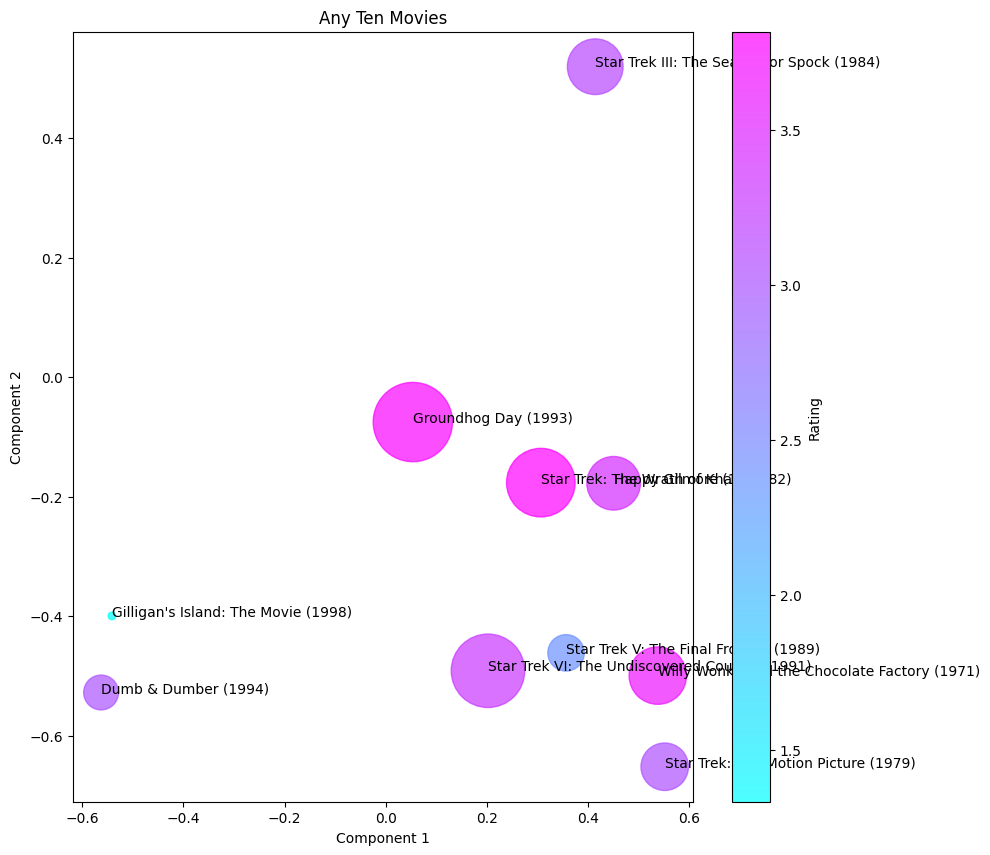

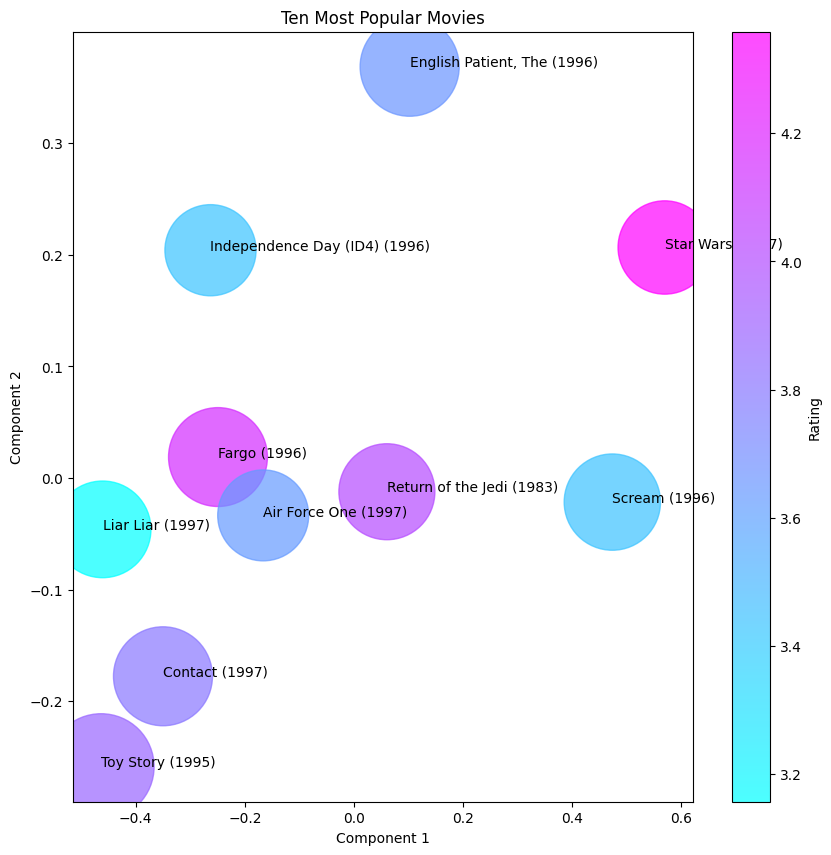

[1500, 1000, 500, 500, 1500, 500, 500, 1000, 500, 500]


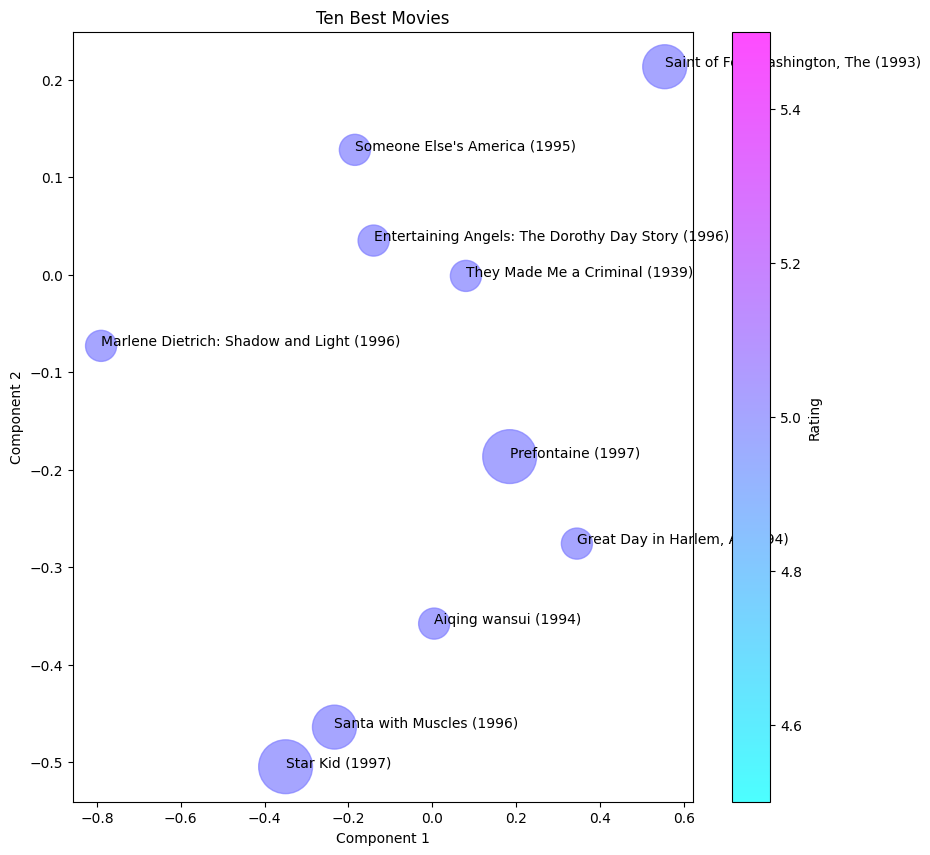

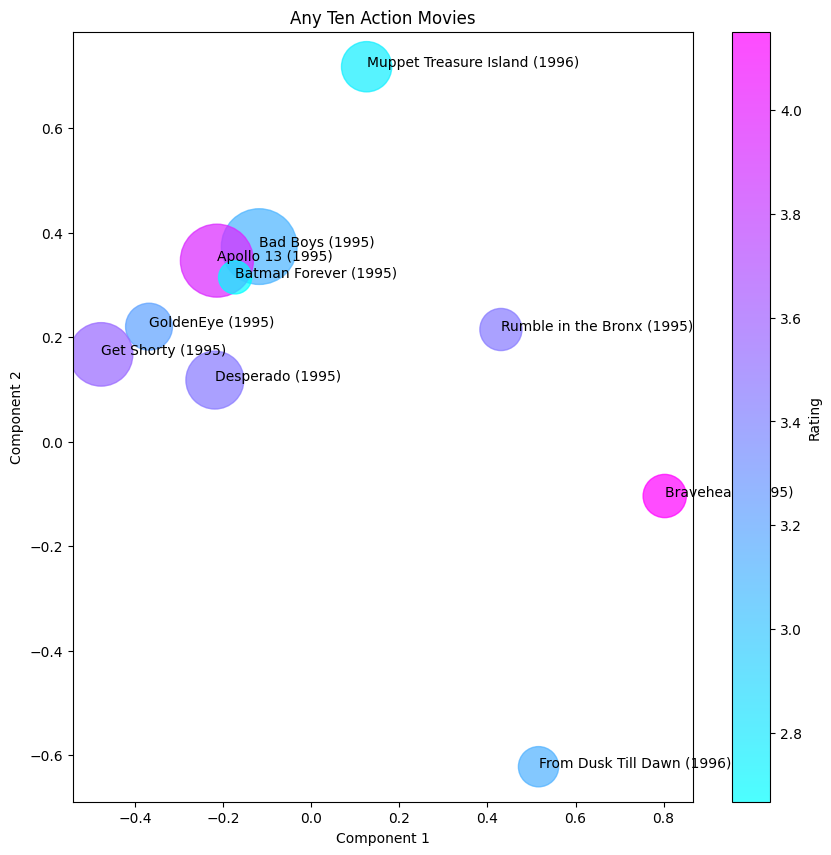

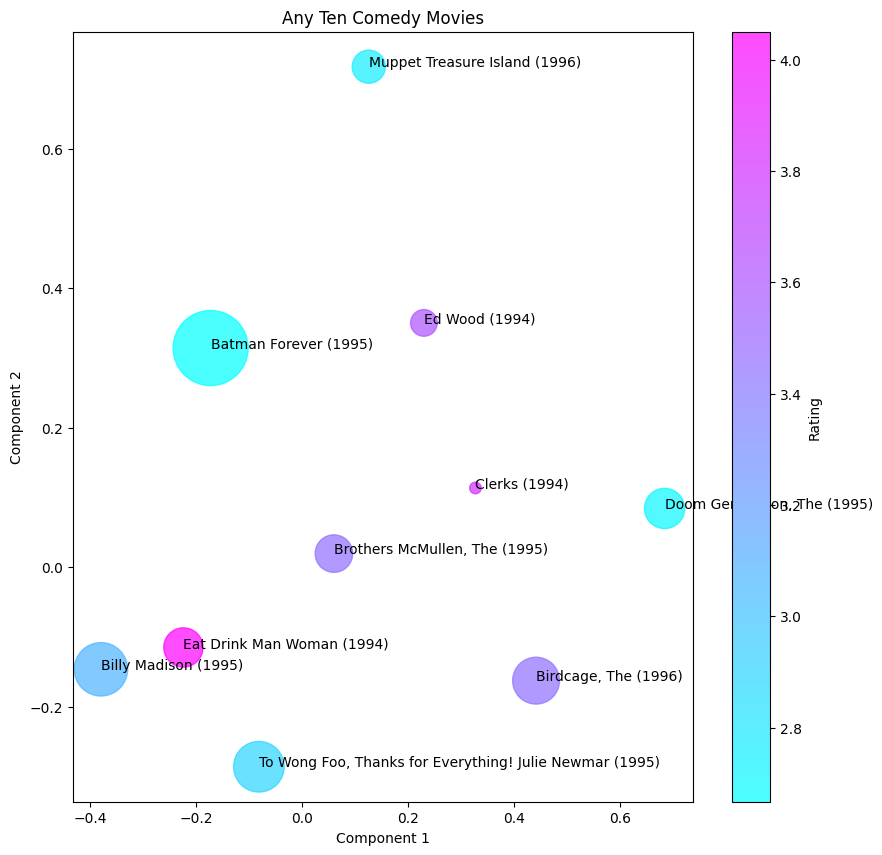

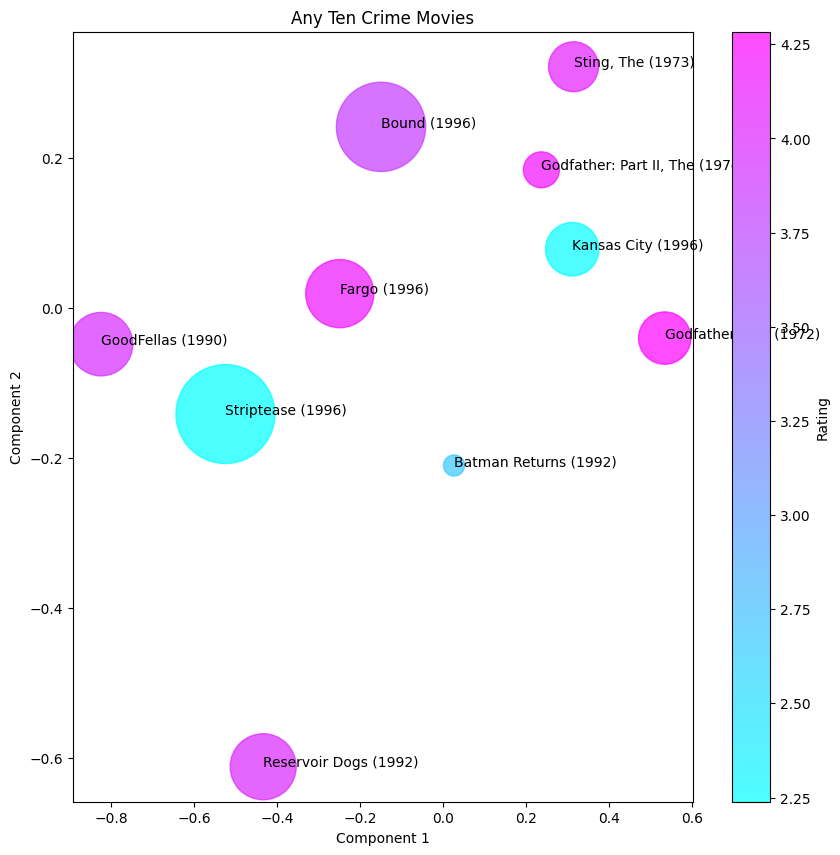

In [ ]:
plotting_any(V_tilde_surprise, ids)
plotting_popular(V_tilde_surprise)
plotting_best(V_tilde_surprise)
plotting_action(V_tilde_surprise)
plotting_comedy(V_tilde_surprise)
plotting_crime(V_tilde_surprise)